## Name: Farel Arden

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-sun-spot-data-1818-to-2019/sunspot_data.csv
/kaggle/input/sunspots/Sunspots.csv


Fungsi dibawah ini digunakan untuk mem-plot grafik

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
dataset=pd.read_csv("../input/sunspots/Sunspots.csv")
dataset.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [4]:
import pandas_profiling as pp
pp.ProfileReport(dataset)

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
time = dataset['Unnamed: 0']
sunspots = dataset['Monthly Mean Total Sunspot Number']

In [6]:
sunspots

0        96.7
1       104.3
2       116.7
3        92.8
4       141.7
        ...  
3260      0.6
3261     14.4
3262     34.0
3263     21.8
3264     10.4
Name: Monthly Mean Total Sunspot Number, Length: 3265, dtype: float64

In [7]:
time

0          0
1          1
2          2
3          3
4          4
        ... 
3260    3260
3261    3261
3262    3262
3263    3263
3264    3264
Name: Unnamed: 0, Length: 3265, dtype: int64

In [8]:
sunspots = np.array(sunspots)
time = np.array(time)

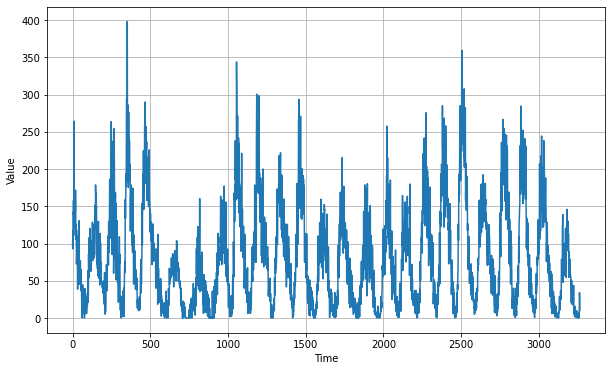

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time, sunspots)

In [10]:
# 80% dari data yang ada = 2612, sehingga kita hanya membutuhkan 653 rows untuk memvalidasi data.
split_time = 2612
time_train = time[:split_time]
x_train = sunspots[:split_time]
time_valid = time[split_time:]
x_valid = sunspots[split_time:]

window_size = 30
batch_size = 32

In [11]:
x_train

array([ 96.7, 104.3, 116.7, ...,  67.7,  80.2,  72.6])

In [12]:
time_train

array([   0,    1,    2, ..., 2609, 2610, 2611])

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
import tensorflow as tf
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True), #declaring the LSTM layers
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


2021-09-17 02:48:21.815280: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-17 02:48:25.535938: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-17 02:48:25.539610: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-17 02:48:25.584109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 02:48:25.585104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-17 02:48:25.585224: I tensorflow/stream_executor/platform/def

In [15]:
optimizer=tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

2021-09-17 02:48:28.346879: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-17 02:48:28.352319: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/100


2021-09-17 02:48:30.964153: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-17 02:48:31.785554: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-17 02:48:31.807087: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


26/26 [==============================] - 9s 18ms/step - loss: 53.9504 - mae: 54.4477
Epoch 2/100
26/26 [==============================] - 1s 17ms/step - loss: 36.5284 - mae: 37.0245
Epoch 3/100
26/26 [==============================] - 1s 17ms/step - loss: 29.4393 - mae: 29.9345
Epoch 4/100
26/26 [==============================] - 1s 18ms/step - loss: 30.4944 - mae: 30.9895
Epoch 5/100
26/26 [==============================] - 1s 17ms/step - loss: 29.7476 - mae: 30.2429
Epoch 6/100
26/26 [==============================] - 1s 17ms/step - loss: 23.0128 - mae: 23.5070
Epoch 7/100
26/26 [==============================] - 1s 17ms/step - loss: 22.1503 - mae: 22.6448
Epoch 8/100
26/26 [==============================] - 1s 16ms/step - loss: 21.7125 - mae: 22.2066
Epoch 9/100
26/26 [==============================] - 1s 17ms/step - loss: 19.6067 - mae: 20.0998
Epoch 10/100
26/26 [==============================] - 1s 17ms/step - loss: 23.2265 - mae: 23.7206
Epoch 11/100
26/26 [=====================